좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.


Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

# 1. setup configuration
## 1.1 Load Libraries

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1.2 set variables

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 8
IMAGE_SIZE = [180, 180]
EPOCHS = 30

# 2. Prepare Dataset
## 2.1 read file names

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 2.2 split file names and count normal/pneumonia

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
print(len(train_filenames))
print(len(val_filenames))

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal count in ts: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia count in ts: " + str(COUNT_PNEUMONIA))

4185
1047
Normal count in ts: 1086
Pneumonia count in ts: 3099


## 2.3 get datasets, counts, and class names

In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training imgs count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("valid imgs count: " + str(VAL_IMG_COUNT))


CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

Training imgs count: 4185
valid imgs count: 1047
['PNEUMONIA' 'NORMAL']


## 2.4 load images

In [6]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 2.5 data preprocessing

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) 
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. Visualize batch data

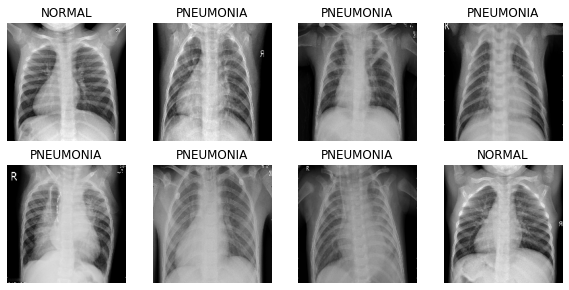

In [8]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(8):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN Modeling
## 4.1 Modeling

In [9]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def balance_weight():
    weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
    weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    return weight_for_0, weight_for_1

## 4.2 CNN model learning

In [10]:
weight_for_0, weight_for_1 = balance_weight()
class_weight = {0: weight_for_0, 1: weight_for_1}

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Weight for class 0: 1.93
Weight for class 1: 0.68
Epoch 1/30
523/523 [==============================] - 49s 93ms/step - loss: 0.4515 - accuracy: 0.7880 - precision: 0.9406 - recall: 0.7618 - val_loss: 0.5793 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/30
523/523 [==============================] - 41s 77ms/step - loss: 0.3598 - accuracy: 0.8317 - precision: 0.9569 - recall: 0.8092 - val_loss: 0.2053 - val_accuracy: 0.9106 - val_precision: 0.9113 - val_recall: 0.9756
Epoch 3/30
523/523 [==============================] - 40s 77ms/step - loss: 0.3334 - accuracy: 0.8533 - precision: 0.9563 - recall: 0.8403 - val_loss: 0.1787 - val_accuracy: 0.9212 - val_precision: 0.9678 - val_recall: 0.9256
Epoch 4/30
523/523 [==============================] - 40s 76ms/step - loss: 0.3389 - accuracy: 0.8456 - precision: 0.9531 - recall: 0.8325 - val_loss: 0.7861 - val_accuracy: 0.6317 - val_precision: 1.0000 - val_recall: 0.5090
Epoch 5/30
523/523 [==========================

## 4.3 CNN model Evaluation

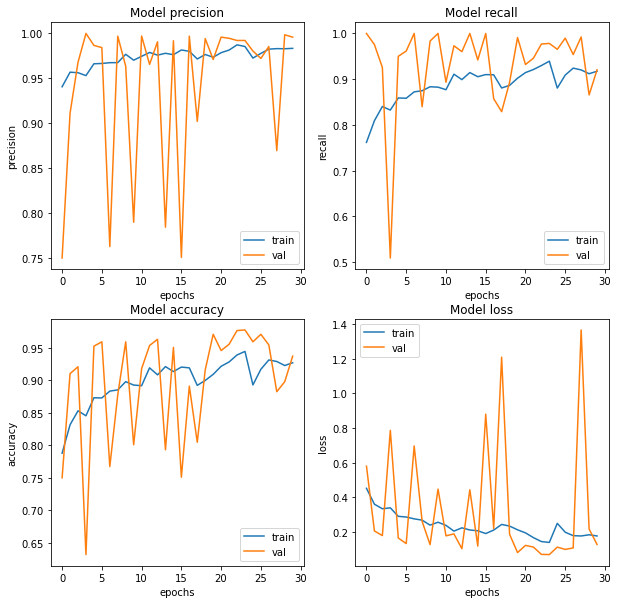

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
loss, acc, prec, rec = model.evaluate(test_ds)

78/78 [==============================] - 4s 50ms/step - loss: 0.4745 - accuracy: 0.8397 - precision: 0.8266 - recall: 0.9410
